Take a look at the [repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) for more information

Useful links:

- [Repo code functionality and implementation overview](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/overview.md)
- [Repo FAQs](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/qa.md):
  - The current code only supports RGB and grayscale images
  - "Typically, the cycle-consistency loss and identity loss decrease during training, while GAN losses oscillate. To evaluate the quality of your results, you need to adopt additional evaluation metrics to your training and test images"
- [Repo Training & Test Tips](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/tips.md)
  - Fine-tuning/continuing training: "To fine-tune a pre-trained model, or resume the previous training, use the --continue_train flag. The program will then load the model based on epoch. By default, the program will initialize the epoch count as 1. Set --epoch_count <int> to specify a different starting epoch count."
  - Image sizes should be a multiple of 4
  - Since GAN loss curves not very helpful, "to check whether the training has converged or not, we recommend periodically generating a few samples and looking at them."

# Install

In [ ]:
#!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
!git clone https://github.com/trishath/pytorch-CycleGAN-and-pix2pix.git

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 3169, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3169 (delta 2), reused 0 (delta 0), pack-reused 3153
Receiving objects: 100% (3169/3169), 102.60 MiB | 40.36 MiB/s, done.
Resolving deltas: 100% (1514/1514), done.


In [ ]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 686kB 25.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=354df843586400138f5a228eed9aee3511c3d7170b9f2ff4763fd604f87c91d4
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=099eef6f663ca4d9652fd284b068234379b7902b79eecc4c87989c8d02e0daef
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


# Datasets

Download one of the official datasets with:

-   `bash ./datasets/download_cyclegan_dataset.sh [apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower]`

Or use your own dataset by creating the appropriate folders and adding in the images.

-   Create a dataset folder under `/dataset` for your dataset.
-   Create subfolders `testA`, `testB`, `trainA`, and `trainB` under your dataset's folder. Place any images you want to transform from a to b (cat2dog) in the `testA` folder, images you want to transform from b to a (dog2cat) in the `testB` folder, and do the same for the `trainA` and `trainB` folders.

## Dataset from original authors (we didn't use this)

In [ ]:
from IPython.display import Javascript
# Limit display height of this dataset downloading cell
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))

!bash ./datasets/download_cyclegan_dataset.sh summer2winter_yosemite

# Rename images with filenames containing the ':' character
def rename_image_files(folder_path):
    for filename in os.listdir(folder_path):
        fullname = os.path.join(folder_path, filename)
        if os.path.isdir(fullname):
            rename_image_files(fullname)
        elif ':' in filename:
            new_filename = filename.replace(':', '_')  # replace ':' with '_'
            os.rename(fullname, os.path.join(folder_path, new_filename))

folder_path = './datasets/summer2winter_yosemite'
rename_image_files(folder_path)

<IPython.core.display.Javascript object>

Specified [summer2winter_yosemite]
for details.

--2021-04-02 22:57:28--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/summer2winter_yosemite.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.244.190
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132640856 (126M) [application/zip]
Saving to: ‘./datasets/summer2winter_yosemite.zip’

./datasets/summer2w 100%[===================>] 126.50M  2.21MB/s    in 60s     

2021-04-02 22:58:28 (2.12 MB/s) - ‘./datasets/summer2winter_yosemite.zip’ saved [132640856/132640856]

Archive:  ./datasets/summer2winter_yosemite.zip
   creating: ./datasets/summer2winter_yosemite/trainA/
  inflating: ./datasets/summer2winter_yosemite/trainA/2014-07-01 10:31:48.jpg  
  inflating: ./datasets/summer2winter_yosemite/trainA/2015-07-01 23:43:46.jpg  
  inflating: ./datasets/summer2winter_yosemite/trainA/2014-07-27 

## Load our own dataset

In [ ]:
### Load our own dataset ###
!mkdir -p ./data/rain_split
# testA, testB, trainA, trainB subfolders
!mkdir -p ./data/rain_split/trainA
!mkdir -p ./data/rain_split/trainB
!mkdir -p ./data/rain_split/testA
!mkdir -p ./data/rain_split/testB

# Split images into subfolders
import os
from PIL import Image

def split_images(orig_directory_path, target_directory_A_path, target_directory_B_path):
    """orig_directory_path must be a directory of only images, with A-B images in each file
    side-by-side with image A on the left and image B on the right.
    target_directory_A_path, target_directory_B_path are where to store the A, B images"""
    processed_count = 0
    for filename in os.listdir(orig_directory_path):
        #AB = Image.open(AB_path).convert('RGB')
        AB = Image.open(os.path.join(orig_directory_path, filename))
        # split AB image into A and B
        w, h = AB.size
        w2 = int(w / 2)
        A = AB.crop((0, 0, w2, h))
        B = AB.crop((w2, 0, w, h))
        A.save(os.path.join(target_directory_A_path, f"{filename}"))
        B.save(os.path.join(target_directory_B_path, f"{filename}"))
        processed_count += 1
    print(f"Processed {processed_count} images in {orig_directory_path}")

for folder_name in ("train", "test"):
    # Put "bad weather" images in A folder, "good weather" images in B folder
    split_images(f"data/rain/{folder_name}", f"data/rain_split/{folder_name}B", f"data/rain_split/{folder_name}A")

# Need to make sure image processing options selected correctly? (eg dimensions)

Processed 700 images in data/rain/train
Processed 100 images in data/rain/test


# Pretrained models

Download one of the official pretrained models with:

-   `bash ./scripts/download_cyclegan_model.sh [apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower]`

Or add your own pretrained model to `./checkpoints/{NAME}_pretrained/latest_net_G.pt`

In [ ]:
!bash ./scripts/download_cyclegan_model.sh summer2winter_yosemite

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [summer2winter_yosemite]
for details.

--2021-04-20 18:45:10--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/summer2winter_yosemite.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/summer2winter_yosemite_pretrained/latest_net_G.pth’

./checkpoints/summe 100%[===================>]  43.46M  2.19MB/s    in 21s     

2021-04-20 18:45:32 (2.07 MB/s) - ‘./checkpoints/summer2winter_yosemite_pretrained/latest_

# Training

-   `python train.py --dataroot ./datasets/horse2zebra --name horse2zebra --model cycle_gan`

Change the `--dataroot` and `--name` to your own dataset's path and model's name. Use `--gpu_ids 0,1,..` to train on multiple GPUs and `--batch_size` to change the batch size. I've found that a batch size of 16 fits onto 4 V100s and can finish training an epoch in ~90s.

Once your model has trained, copy over the last checkpoint to a format that the testing model can automatically detect:

Use `cp ./checkpoints/horse2zebra/latest_net_G_A.pth ./checkpoints/horse2zebra/latest_net_G.pth` if you want to transform images from class A to class B and `cp ./checkpoints/horse2zebra/latest_net_G_B.pth ./checkpoints/horse2zebra/latest_net_G.pth` if you want to transform images from class B to class A.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!python train.py --dataroot /content/pytorch-CycleGAN-and-pix2pix/data/rain_split --name deweather_cycle --model cycle_gan \
                 --preprocess 'scale_width_and_crop' --save_epoch_freq 1 \
                 --checkpoints_dir /content/gdrive/My\ Drive/CSC413\ Group\ 61/CycleGAN_Checkpoints
# Reduce # epochs? --n_epochs 20, --n_epochs_decay 50?
# Increase batch size to speed up training? eg --batch_size 2, or --batch_size 4
# Try to use similar method as paper to preserver color style? (original Monet -> photo and flower enhancement used lambda_identity of 0.5 * 10 = 5)
# --lambda_identity = 3

----------------- Options ---------------
               batch_size: 1                             
                    beta1: 0.5                           
          checkpoints_dir: /content/gdrive/My Drive/CSC413 Group 61/CycleGAN_Checkpoints	[default: ./checkpoints]
           continue_train: False                         
                crop_size: 256                           
                 dataroot: /content/pytorch-CycleGAN-and-pix2pix/data/rain_split	[default: None]
             dataset_mode: unaligned                     
                direction: AtoB                          
              display_env: main                          
             display_freq: 400                           
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
          display_winsize: 256                     

# Testing

> from https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix:
> The option --model test is used for generating results of CycleGAN only for one side. This option will automatically set --dataset_mode single, which only loads the images from one set. On the contrary, using --model cycle_gan requires loading and generating results in both directions, which is sometimes unnecessary. The results will be saved at ./results/. Use --results_dir {directory_path_to_save_result} to specify the results directory.


In [19]:
#%mkdir -p results
# Testing on DAWN dataset
# (saving results directly to Google Drive gave file access errors midway)
!python test.py --dataroot /content/gdrive/My\ Drive/CSC413\ Group\ 61/DAWN/Rain --name deweather_cycle --model test --no_dropout \
                --direction AtoB --checkpoints_dir /content/gdrive/My\ Drive/CSC413\ Group\ 61/CycleGAN_Checkpoints \
                --num_test 350
#                --results_dir /content/pytorch-CycleGAN-and-pix2pix/results/Rain
!python test.py --dataroot /content/gdrive/My\ Drive/CSC413\ Group\ 61/DAWN/Snow --name deweather_cycle --model test --no_dropout \
                --direction AtoB --checkpoints_dir /content/gdrive/My\ Drive/CSC413\ Group\ 61/CycleGAN_Checkpoints \
                --num_test 350
#                --results_dir /content/pytorch-CycleGAN-and-pix2pix/results/Snow
!python test.py --dataroot /content/gdrive/My\ Drive/CSC413\ Group\ 61/DAWN/Fog --name deweather_cycle --model test --no_dropout \
                --direction AtoB --checkpoints_dir /content/gdrive/My\ Drive/CSC413\ Group\ 61/CycleGAN_Checkpoints \
                --num_test 350
#                --results_dir /content/pytorch-CycleGAN-and-pix2pix/results/Fog
!python test.py --dataroot /content/gdrive/My\ Drive/CSC413\ Group\ 61/DAWN/Sand --name deweather_cycle --model test --no_dropout \
                --direction AtoB --checkpoints_dir /content/gdrive/My\ Drive/CSC413\ Group\ 61/CycleGAN_Checkpoints \
                --num_test 350
#                --results_dir /content/pytorch-CycleGAN-and-pix2pix/results/Sand

# The option below gave file access errors midway unfortunately
#                --results_dir /content/gdrive/My\ Drive/CSC413\ Group\ 61/CycleGAN_Results

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/gdrive/My Drive/CSC413 Group 61/CycleGAN_Checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/gdrive/My Drive/CSC413 Group 61/DAWN/Rain	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                      

In [20]:
# Create zip file of test results for download
!zip -r cyclegan_test_results.zip ./results/deweather_cycle/test_latest/images

updating: results/deweather_cycle/test_latest/images/ (stored 0%)
updating: results/deweather_cycle/test_latest/images/snow_storm-060_real.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/rain_storm-007_fake.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/dusttornado-033_fake.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/rain_storm-090_fake.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/dusttornado-032_fake.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/snow_storm-025_real.png (deflated 1%)
updating: results/deweather_cycle/test_latest/images/snow_storm-019_real.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/snow_storm-010_fake.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/snow_storm-061_fake.png (deflated 0%)
updating: results/deweather_cycle/test_latest/images/rain_storm-005_real.png (deflated 0%)
updating: results/dewe

# Visualize

## CycleGAN Day/Night driving conversion, by original authors

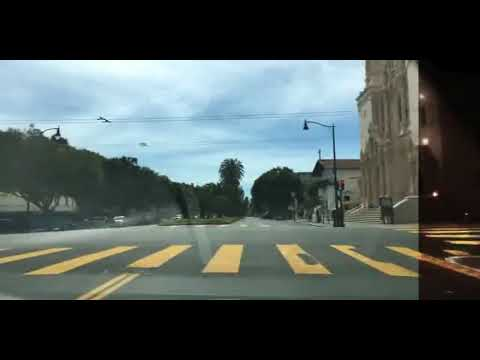

In [ ]:
# CycleGAN Day/Night driving conversion, by original authors
from IPython.display import YouTubeVideo
YouTubeVideo('N7KbfWodXJE')

## Test results

In [ ]:
import matplotlib.pyplot as plt
# Real image 
img = plt.imread('/content/gdrive/MyDrive/CSC413 Group 61/CycleGAN_Results/deweather_cycle/test_latest/images/dusttornado-015_real.png')
plt.imshow(img)
# Generated deweathered image
img = plt.imread('/content/gdrive/MyDrive/CSC413 Group 61/CycleGAN_Results/deweather_cycle/test_latest/images/dusttornado-015_fake.png')
plt.imshow(img)

# Generating Loss Plot

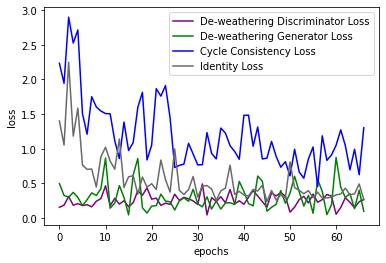

In [ ]:
import matplotlib.pyplot as plt

da_loss = []
ga_loss = []
cycle_a = []
idt_a = []

results_file_path = '/content/pytorch-CycleGAN-and-pix2pix/results.txt'
with open(results_file_path) as f:
    for i, row in enumerate(f.readlines()):
        if "iters: 700," not in row:
            continue
        info = row.split()

        da_loss.append(float(info[9]))
        ga_loss.append(float(info[11]))
        cycle_a.append(float(info[13]))
        idt_a.append(float(info[15]))

plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(list(range(len(da_loss))), da_loss, color='purple', label='De-weathering Discriminator Loss')
plt.plot(list(range(len(da_loss))), ga_loss, color='green', label='De-weathering Generator Loss')
plt.plot(list(range(len(da_loss))), cycle_a, color='blue', label='Cycle Consistency Loss')
plt.plot(list(range(len(da_loss))), idt_a, color='dimgray', label='Identity Loss')
plt.legend()
plt.show()

## Previous code when test results were saved to Colab instead of Google Drive

In [ ]:
# Download results folder to your computer to view the index.html with properly displayed images
from google.colab import files

# Limit display height of this dataset downloading cell
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))

# Zip and download entire folder
!zip -r test_results.zip ./results/deweather_cycle/test_latest
files.download("deweather_cycle_test_results.zip")

<IPython.core.display.Javascript object>

  adding: results/summer2winter_yosemite_pretrained/test_latest/ (stored 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/ (stored 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/2011-06-03 03_36_41_real.png (deflated 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/2011-05-29 13_29_21_real.png (deflated 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/2011-06-09 12_02_20_real.png (deflated 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/2011-08-13 16_50_20_real.png (deflated 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/2011-08-18 18_37_21_fake.png (deflated 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/2011-08-17 22_49_50_fake.png (deflated 0%)
  adding: results/summer2winter_yosemite_pretrained/test_latest/images/2011-07-03 11_01_20_real.png (deflated 0%)
  adding: results/summer2winter_yosemite_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Display html file of test images in colab: doesn't quite work yet
from IPython.display import HTML
prev_cwd = os.getcwd()
os.chdir('./results/summer2winter_yosemite_pretrained/test_latest')
HTML(filename='./index.html')
os.chdir(prev_cwd)  # Restore previous working directory